In [116]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
# some function
def f(x):
    return 3*x**2 - 4*x + 5

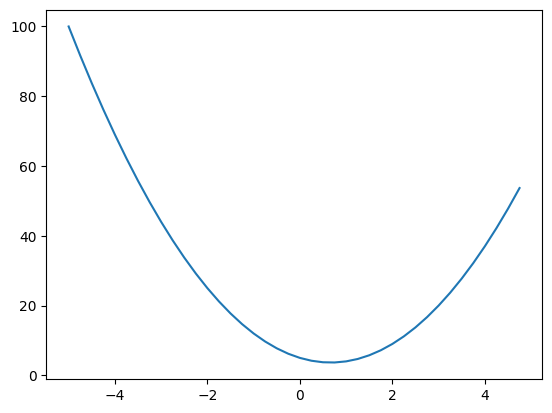

In [118]:
# plot the function
xs = np.arange(-5, 5, 0.25) # from -5 to 5 every 0.25
ys = f(xs)
plt.plot(xs, ys)

In [119]:
# derivative
h = 0.0000001
x = 2/3
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [120]:
# more complex function (more variables)
a = 2.0
b = -3.0
c = 10
d = a * b + c
print(d)

4.0


In [121]:
# derivatives
h = 0.001

a = 2.0
b = -3.0
c = 10

d1 = a * b + c
da = (a + h) * b + c
print('a', (da - d1) / h)

db = a * (b + h) + c
print('b', (db - d1) / h)

dc = a * b + (c + h)
print('c', (dc - d1) / h)

a -3.0000000000001137
b 1.9999999999997797
c 0.9999999999994458


In [122]:
# value class
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other    

    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        reverse_topological_order = []
        visited = set()

        def reverse_topological_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    reverse_topological_sort(child)
                reverse_topological_order.append(node)
        
        reverse_topological_sort(self)

        self.grad = 1.0
        for node in reversed(reverse_topological_order):
            node._backward()

In [123]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(2.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = "L"
L

Value(data=8.0)

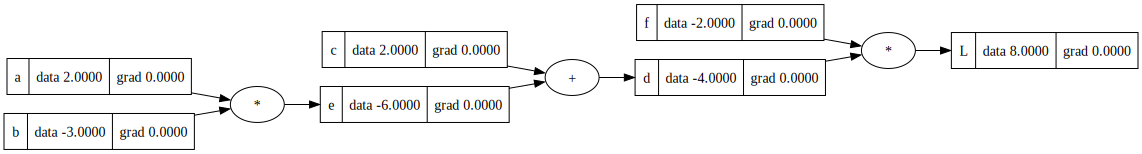

In [124]:
# makes graphs
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        # for any value in the graph, create a rectangular ('record') node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape = "record")
        if node._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + node._op, label = node._op)
            # and connect this node to it
            dot.edge(uid + node._op, uid)
    
    for node1, node2 in edges:
        # connect node1 to the op node of node2
        dot.edge(str(id(node1)), str(id(node2)) + node2._op)
    
    return dot

draw_dot(L)

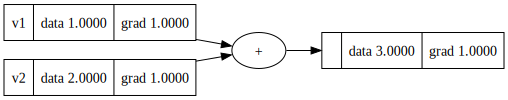

In [125]:
v1 = Value(1.0, label="v1")
v2 = Value(2.0, label="v2")
v2 = v2 + v1
v2.backward()
draw_dot(v2)

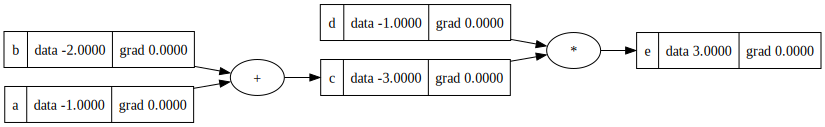

In [126]:
a = Value(-1.0, label="a")
b = Value(-2.0, label="b")
d = Value(-1.0, label="d")
c = a + b
e = c * d
c.label='c'
e.label='e'

# e.backward()

draw_dot(e)

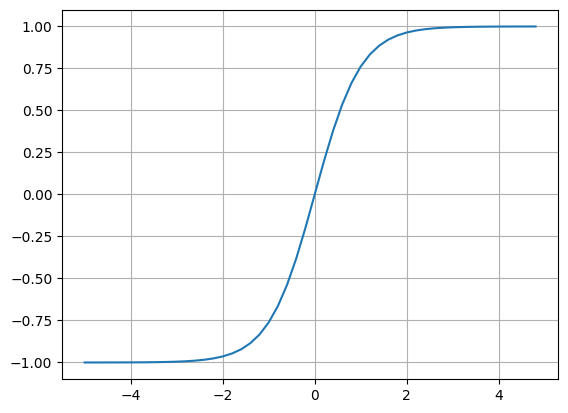

In [127]:
# tanh function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

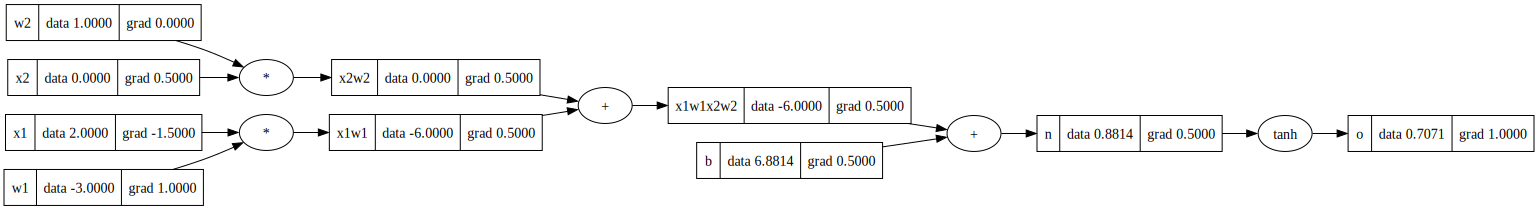

In [128]:
# neuron inputs
input1 = Value(2.0, label='x1')
input2 = Value(0.0, label='x2')
# neuron weights
weight1 = Value(-3.0, label='w1')
weight2 = Value(1.0, label='w2')
# neuron bias
bias = Value(6.88137, label='b')

input1weight1 = input1 * weight1; input1weight1.label='x1w1'
input2weight2 = input2 * weight2; input2weight2.label='x2w2'
input1weight1input2weight2 = input1weight1 + input2weight2; input1weight1input2weight2.label='x1w1x2w2'
neuron = input1weight1input2weight2 + bias; neuron.label='n'
output = neuron.tanh(); output.label = 'o'

output.backward()
draw_dot(output)

In [129]:
import random


# Neuron
class Neuron:

    def __init__(self, number_of_inputs):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, inputs):
        actual = sum((wi * xi for wi, xi in zip(self.weights, inputs)), self.bias)
        output = actual.tanh()
        return output

    def parameters(self):
        return self.weights + [self.bias]
    

# Layer of neurons
class Layer:

    def __init__(self, number_of_inputs, number_of_neurons):
        self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_neurons)]

    def __call__(self, inputs):
        outputs = [neuron(inputs) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]


# Multi Layer Perceptron
class MLP:

    def __init__(self, number_of_inputs, neurons_per_layer):
        size = [number_of_inputs] + neurons_per_layer
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(neurons_per_layer))]

    def __call__(self, inputs):
        for layer in self.layers:
            inputs= layer(inputs)
        return inputs
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

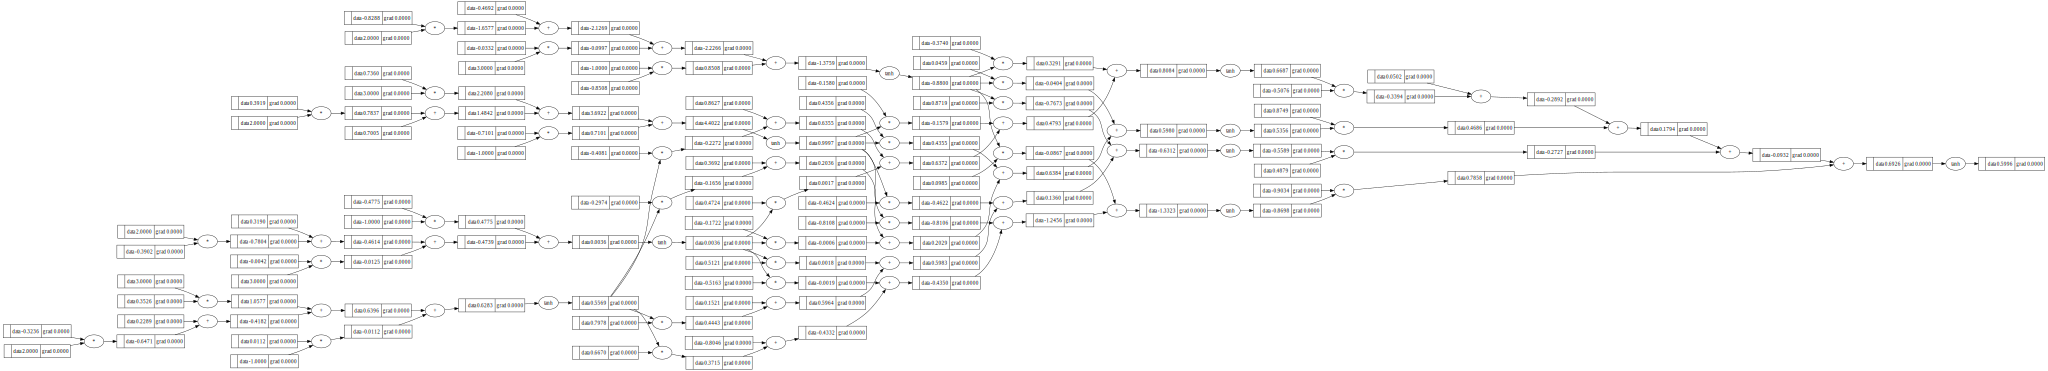

In [130]:
inputs = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(inputs)
draw_dot(n(inputs))

In [131]:
n.parameters()

[Value(data=-0.32355187968049237),
 Value(data=0.3525719944647949),
 Value(data=0.011247136610533337),
 Value(data=0.22894158789164876),
 Value(data=-0.3901881019412574),
 Value(data=-0.004172174517009575),
 Value(data=-0.4774893135054179),
 Value(data=0.31900536387410017),
 Value(data=0.391869696524175),
 Value(data=0.7359898201547044),
 Value(data=-0.7100798425565493),
 Value(data=0.7004540338950294),
 Value(data=-0.8288464579231087),
 Value(data=-0.0332331967844699),
 Value(data=-0.8507584125866032),
 Value(data=-0.4692498899600881),
 Value(data=-0.4080593146756373),
 Value(data=0.4724065149495875),
 Value(data=-0.15798600353798986),
 Value(data=-0.37397241865034814),
 Value(data=0.8627360579782666),
 Value(data=-0.2973710724576868),
 Value(data=-0.17217557015061002),
 Value(data=0.43563533190303394),
 Value(data=0.04594588789074372),
 Value(data=0.36916390617144557),
 Value(data=0.7978458187959372),
 Value(data=0.5121193113588443),
 Value(data=-0.46238290391303805),
 Value(data=0.8

In [132]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.778430323188858),
 Value(data=-0.7232181980521268),
 Value(data=-0.8212767634634187),
 Value(data=-0.7980107622205684)]

In [133]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.504207276666238)

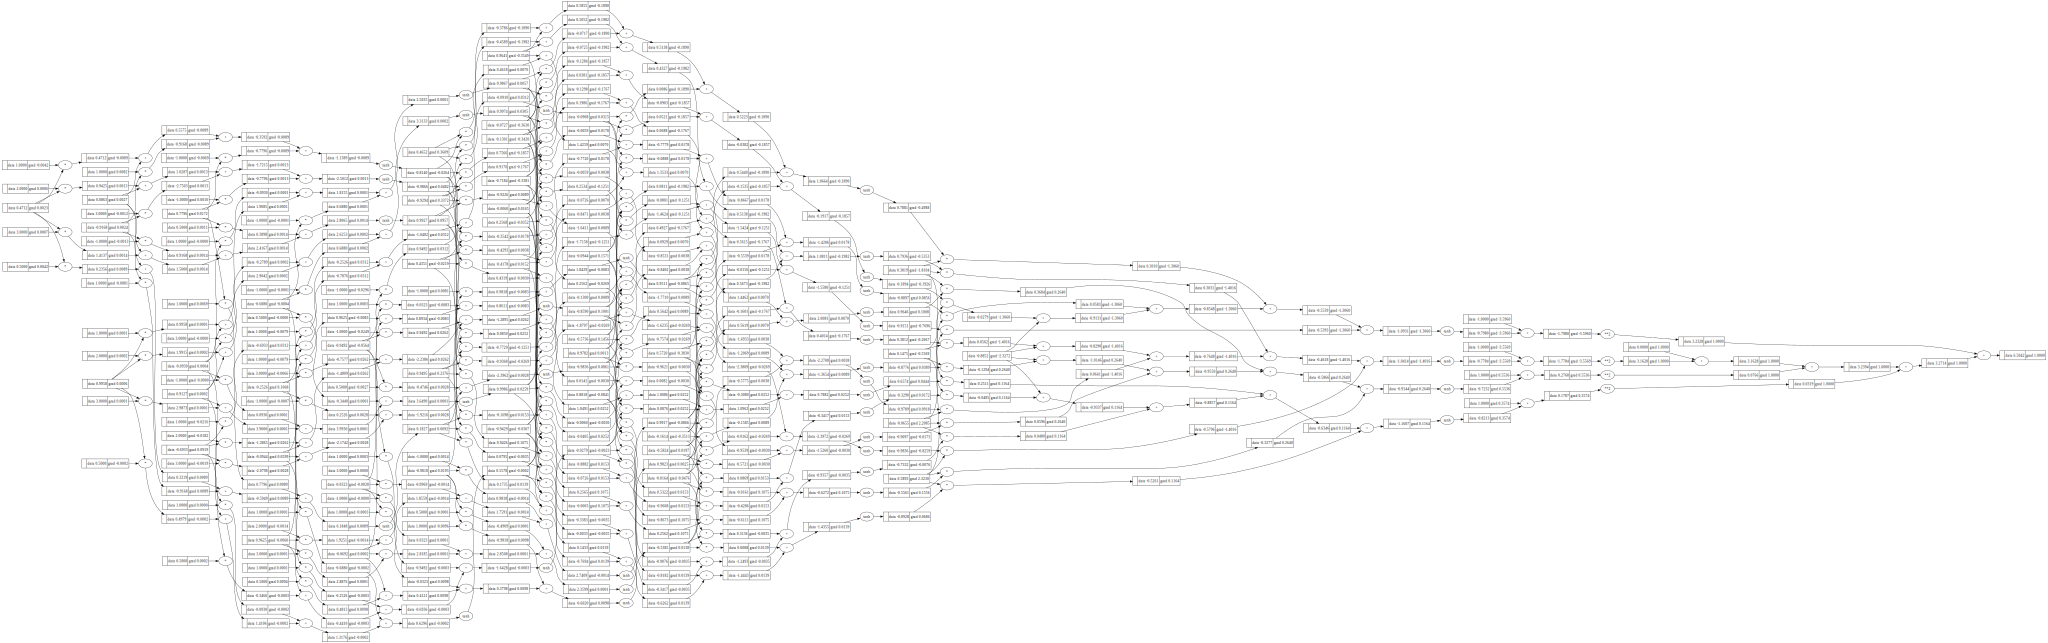

In [134]:
loss.backward()
draw_dot(loss)

In [135]:
for k in range(100):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    if k % 10 == 0:
        print(k, loss.data)


0 6.504207276666238
10 0.056256999767691517
20 0.030622270841907315
30 0.020716233072121913
40 0.015499238232964393
50 0.012299449876728258
60 0.010145692098771676
70 0.008601975531674074
80 0.007444130599544281
90 0.006545362857055141


In [63]:
ypred

[Value(data=0.9762049441220164),
 Value(data=-0.9824037970992787),
 Value(data=-0.9586120484165249),
 Value(data=0.9700152918851749)]